
Automate NYT Analysis
---------------------
Este notebook procesa los 31 archivos nyt1.csv a nyt31.csv uno a uno,
calcula métricas relevantes y las guarda en un CSV unificado.

Siguiendo la recomendación del libro, no se han cargado todos los datasets
en memoria al mismo tiempo; se procesa cada archivo y luego se descarta.



Resumen de métricas diarias:
     filename  total_users  total_impressions  mean_impressions  total_clicks  \
0   nyt1.csv       458441            2295559          5.007316         42449   
1   nyt2.csv       449935            2249486          4.999580         41752   
2   nyt3.csv       440370            2200239          4.996342         40630   
3   nyt4.csv       442857            2215850          5.003534         40990   
4   nyt5.csv       370328            1851162          4.998709         34131   
5   nyt6.csv       764510            3819108          4.995498         70532   
6   nyt7.csv       452493            2262518          5.000117         41870   
7   nyt8.csv       463196            2316326          5.000747         42465   
8   nyt9.csv       459472            2296556          4.998250         42585   
9  nyt10.csv       452766            2262917          4.997984         41725   

   mean_ctr  pct_invalid  
0  0.018471    29.907011  
1  0.018462    29.909209  
2  0.018

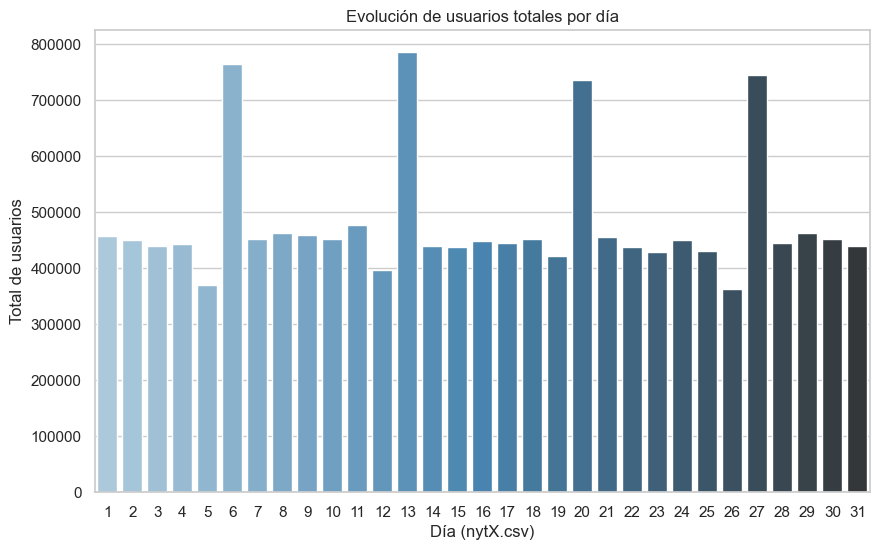

In [9]:

# ============================
# 1. Importar librerías
# ============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")

# ============================================
# 2. Definir función para procesar 1 archivo
# ============================================
def process_nyt_file(file_path):
    """
    Lee un archivo CSV con formato nytX.csv
    y retorna un diccionario con métricas clave.

    Parámetros:
    -----------
    file_path : Path or str
        Ruta del archivo a procesar.

    Retorna:
    --------
    metrics_dict : dict
        Diccionario con métricas agregadas del archivo.
    """

    # Leer los datos
    df = pd.read_csv(file_path)

    # Crear categorías de edad
    bins = [-float("inf"), 0, 17, 24, 34, 44, 54, 64, float("inf")]
    labels = ["Invalid", "<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
    df["age_group"] = pd.cut(df["Age"], bins=bins, labels=labels)

    # Crear CTR
    df["CTR"] = df.apply(lambda row: row["Clicks"] / row["Impressions"] if row["Impressions"] > 0 else None, axis=1)

    # Categorizar comportamiento
    def categorize(row):
        if row["Impressions"] == 0:
            return "NoImps"
        elif row["Clicks"] > 0:
            return "Clicks"
        else:
            return "Imps"

    df["scode"] = df.apply(categorize, axis=1)
    df["scode"] = df["scode"].astype("category")

    # Calcular métricas que quieras guardar
    # (puedes ampliarlas según tus necesidades)
    total_users = len(df)  # número de filas
    total_impressions = df["Impressions"].sum()
    mean_impressions = df["Impressions"].mean()
    total_clicks = df["Clicks"].sum()
    mean_ctr = df["CTR"].mean(skipna=True)

    # Ejemplo: % de usuarios 'Invalid'
    pct_invalid = (df["age_group"] == "Invalid").mean() * 100

    metrics_dict = {
        "filename": file_path.name,
        "total_users": total_users,
        "total_impressions": total_impressions,
        "mean_impressions": mean_impressions,
        "total_clicks": total_clicks,
        "mean_ctr": mean_ctr,
        "pct_invalid": pct_invalid
    }

    # Eliminar df para simular que no guardamos en memoria
    del df

    return metrics_dict

# ============================================
# 3. Iterar sobre nyt1..nyt31 y recolectar métricas
# ============================================

# Lista para guardar los resultados de cada día
results = []

# Ruta base (asumiendo que este notebook está en /chapter-02/notebook/
# y los CSV están en /chapter-02/data/)
root = Path.cwd()
data_path = root.parent / "data"

# Suponemos que existen los archivos nyt1.csv a nyt31.csv
for i in range(1, 32):
    csv_file = data_path / f"nyt{i}.csv"
    if csv_file.exists():
        day_metrics = process_nyt_file(csv_file)
        results.append(day_metrics)
    else:
        print(f"No se encontró el archivo: {csv_file}")

# ============================================
# 4. Convertir los resultados en DataFrame y guardarlos
# ============================================
df_results = pd.DataFrame(results)

# Ordenar columnas para más legibilidad (opcional)
ordered_cols = ["filename", "total_users", "total_impressions", "mean_impressions",
                "total_clicks", "mean_ctr", "pct_invalid"]
df_results = df_results[ordered_cols]

print("Resumen de métricas diarias:\n", df_results.head(10))

# Guardar en CSV para análisis futuro
output_csv = data_path / "daily_metrics.csv"
df_results.to_csv(output_csv, index=False)
print(f"\nMétricas agregadas guardadas en: {output_csv}")

# Escogemos uno de los días para analizar con más detalle
one_file = data_path / "nyt15.csv"
df15 = pd.read_csv(one_file)

# Crear categorías de edad
bins = [-float("inf"), 0, 17, 24, 34, 44, 54, 64, float("inf")]
labels = ["Invalid", "<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
df15["age_group"] = pd.cut(df15["Age"], bins=bins, labels=labels)

# Crear CTR
df15["CTR"] = df15.apply(lambda row: row["Clicks"] / row["Impressions"] if row["Impressions"] > 0 else None, axis=1)

# Crear columna "group"
df15["group"] = df15["age_group"].apply(lambda x: "Invalid" if x == "Invalid" else "Valid")

# Agrupación y cálculo de CTR medio
ctr_by_group = df15.groupby("group")["CTR"].mean()
print(f"CTR promedio en nyt15.csv por grupo (Invalid vs Valid):\n{ctr_by_group}")

# ============================================
# 5. Visualizar evolución métricas (OPCIONAL)
# ============================================

# 1) Crear la columna day_number desde la filename, y ordenarla
df_results["day_number"] = df_results["filename"].str.extract(r"(\d+)")
df_results["day_number"] = df_results["day_number"].astype(int)
df_results.sort_values("day_number", inplace=True)

# 2) Convertir day_number a string para obtener un gradiente de color
df_results["day_number_cat"] = df_results["day_number"].astype(str)

# 3) Graficar con barplot usando day_number_cat
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_results,
    x="day_number_cat",
    y="total_users",
    hue="day_number_cat",
    palette="Blues_d",
    dodge=False,
    legend=False
)
plt.title("Evolución de usuarios totales por día")
plt.xlabel("Día (nytX.csv)")
plt.ylabel("Total de usuarios")
plt.show()


In [7]:
one_file = data_path / "nyt31.csv"
df31 = pd.read_csv(one_file)

bins = [-float("inf"), 0, 17, 24, 34, 44, 54, 64, float("inf")]
labels = ["Invalid", "<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]

df31["age_group"] = pd.cut(df31["Age"], bins=bins, labels=labels)
df31["CTR"] = df31.apply(lambda row: row["Clicks"] / row["Impressions"] if row["Impressions"] > 0 else None, axis=1)
df31["group"] = df31["age_group"].apply(lambda x: "Invalid" if x == "Invalid" else "Valid")

ctr_by_group_31 = df31.groupby("group")["CTR"].mean()
print("CTR promedio en nyt31.csv por grupo (Invalid vs Valid):\n", ctr_by_group_31)


CTR promedio en nyt31.csv por grupo (Invalid vs Valid):
 group
Invalid    0.028632
Valid      0.014316
Name: CTR, dtype: float64


### Análisis Comparativo: Día 15 vs. Día 31

Al comparar el comportamiento de los usuarios en los días 15 y 31, se constata una diferencia sustancial en la proporción de individuos clasificados como “Invalid” (aquellos con `Age = 0`), así como en su impacto en el CTR (Click-Through Rate) global:

- **Día 15**: ~45% de usuarios Invalid, con un CTR de ~2.85% en ese subgrupo, frente a ~1.40% en los usuarios Valid. Como resultado, el CTR global se aproxima a ~2.05%.  
- **Día 31**: La proporción de usuarios Invalid desciende a ~30%, manteniendo un CTR del orden de 2.86% en dicho subgrupo. Esto se traduce en un CTR global de ~1.86%, notoriamente menor al observado en días 15–30.

Estas cifras sugieren que, si bien los usuarios Invalid continúan mostrando un CTR notablemente elevado, su menor peso relativo en el total de la población reduce el promedio global. El comportamiento registrado indica un posible **“cambio de escenario”** a partir del día 15, durante el cual la presencia de usuarios anónimos aumenta significativamente, elevando el CTR general. Hacia el día 31, la proporción retorna a niveles similares a los del período inicial, lo que conlleva una disminución en la métrica global, pese a que la diferencia entre subgrupos (Invalid vs. Valid) siga siendo pronunciada.

En términos de análisis exploratorio, esta discontinuidad destaca la necesidad de examinar no solo el promedio general de clics, sino también la **composición de la base de usuarios** y la variación en el tiempo de subgrupos clave. Asimismo, pone de manifiesto cómo el incremento o la disminución de un segmento con alta propensión a la interacción (Invalid) puede influir de manera decisiva en las métricas agregadas de la plataforma.


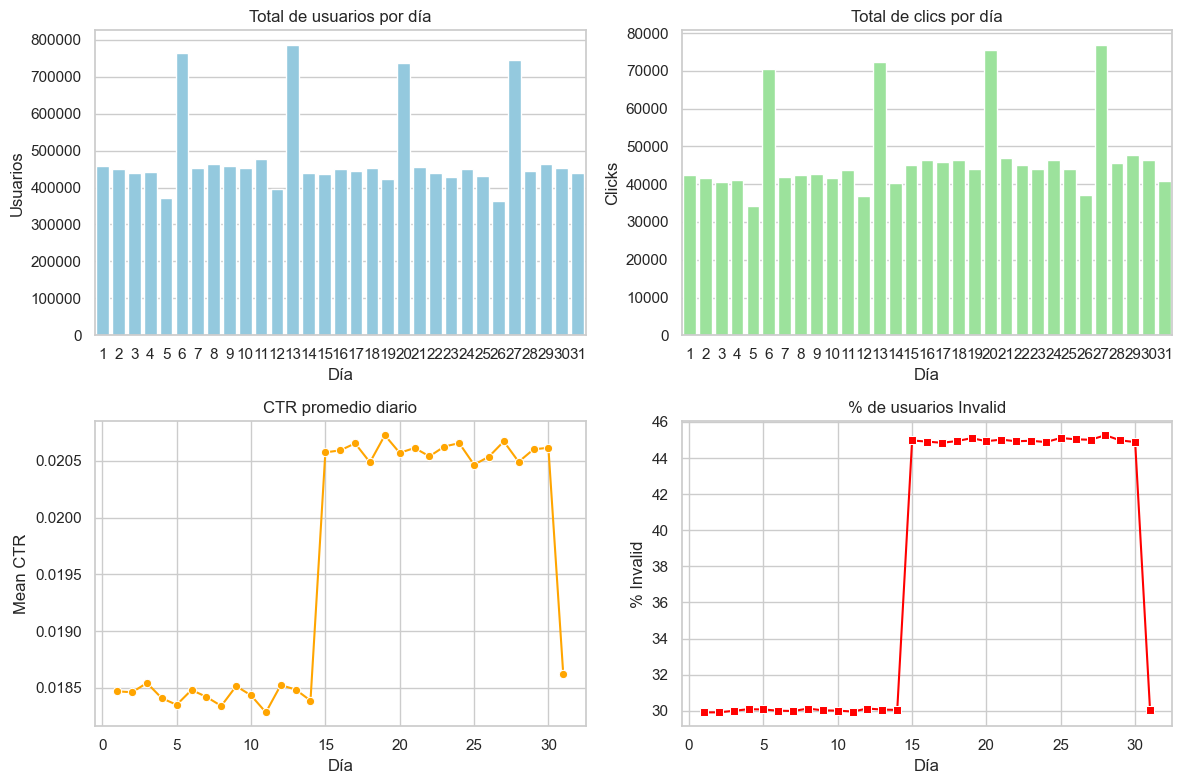

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # para iterar fácilmente en un array 1D

# 1) Total de usuarios
sns.barplot(data=df_results, x="day_number", y="total_users", color="skyblue", ax=axes[0])
axes[0].set_title("Total de usuarios por día")
axes[0].set_xlabel("Día")
axes[0].set_ylabel("Usuarios")

# 2) Total de clics
sns.barplot(data=df_results, x="day_number", y="total_clicks", color="lightgreen", ax=axes[1])
axes[1].set_title("Total de clics por día")
axes[1].set_xlabel("Día")
axes[1].set_ylabel("Clicks")

# 3) Mean CTR
sns.lineplot(data=df_results, x="day_number", y="mean_ctr", color="orange", ax=axes[2], marker="o")
axes[2].set_title("CTR promedio diario")
axes[2].set_xlabel("Día")
axes[2].set_ylabel("Mean CTR")

# 4) % Invalid
sns.lineplot(data=df_results, x="day_number", y="pct_invalid", color="red", ax=axes[3], marker="s")
axes[3].set_title("% de usuarios Invalid")
axes[3].set_xlabel("Día")
axes[3].set_ylabel("% Invalid")

plt.tight_layout()
plt.show()


# Análisis Multi-Día de Métricas de Usuarios y Clics

## Resumen

A lo largo de los 31 días analizados, se identificaron patrones y discontinuidades significativas en las métricas de uso y comportamiento de clics.

### Hallazgos Principales

#### 1. Dinámica de Usuarios e Impresiones
- **Variabilidad Diaria**: Fluctuaciones notables en el volumen total de usuarios e impresiones.
- **Posibles Factores**: Eventos simulados, cambios en la composición de la audiencia.

#### 2. Comportamiento del Click-Through Rate (CTR)
- **Rango Típico**: 1.8% - 2.0% en la mayoría de los días
- **Periodo de Elevación**: Días 15-30, con picos cercanos a 2.05%
- **Tendencia Final**: Descenso hacia 1.86% al aproximarse al día 31

#### 3. Análisis de Subgrupos: Invalid vs. Valid

##### Características del Subgrupo Invalid
- CTR significativamente superior al grupo Valid
- Proporción máxima de ~45% en días centrales
- Reducción a ~30% hacia el día 31

### Hipótesis Interpretativas

1. **Cambio de Escenario Simulado**
   - Modificación intencional de la población de usuarios alrededor del día 15
   - Incremento de usuarios "Invalid" con alta propensión a clics
   - Reversión gradual hacia condiciones iniciales

2. **Implicaciones Metodológicas**
   - Importancia de desagregar métricas globales
   - Necesidad de análisis de subgrupos para comprender variaciones

## Visualizaciones Clave

### Gráficos Comparativos
- Total de usuarios por día
- Volumen de clics diarios
- Evolución del CTR promedio
- Proporción de usuarios Invalid

## Conclusiones

El análisis destaca la complejidad de los datos de usuario, manifestando que:
- Las métricas agregadas pueden ocultar comportamientos subyacentes
- La composición demográfica impacta significativamente las estadísticas globales
- Un análisis exploratorio detallado es crucial para una comprensión integral

### Recomendaciones

1. Implementar segmentación sistemática
2. Monitorear cambios en la composición de usuarios
3. Desarrollar modelos que contemplen la heterogeneidad de subgrupos

## Limitaciones

- Datos simulados/sintéticos
- Posible sesgo en la generación de datos
- Necesidad de validación con conjuntos de datos reales